<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1">Imports</a></span></li><li><span><a href="#Data-pre-processing" data-toc-modified-id="Data-pre-processing-2">Data pre-processing</a></span></li><li><span><a href="#Function-definitions" data-toc-modified-id="Function-definitions-3">Function definitions</a></span></li><li><span><a href="#HistGradientBoostingClassifier" data-toc-modified-id="HistGradientBoostingClassifier-4">HistGradientBoostingClassifier</a></span></li><li><span><a href="#Class-weights" data-toc-modified-id="Class-weights-5">Class weights</a></span></li><li><span><a href="#Initial-Classifiers" data-toc-modified-id="Initial-Classifiers-6">Initial Classifiers</a></span></li><li><span><a href="#Important-features" data-toc-modified-id="Important-features-7">Important features</a></span></li><li><span><a href="#Hyperparameter-tuning" data-toc-modified-id="Hyperparameter-tuning-8">Hyperparameter tuning</a></span><ul class="toc-item"><li><span><a href="#Including-the-V***-columns" data-toc-modified-id="Including-the-V***-columns-8.1">Including the V*** columns</a></span></li><li><span><a href="#Only-features-deemed-important-by-RF-model-interpretation-with-V***-features" data-toc-modified-id="Only-features-deemed-important-by-RF-model-interpretation-with-V***-features-8.2">Only features deemed important by RF model interpretation with V*** features</a></span></li><li><span><a href="#Only-features-deemed-important-by-RF-model-interpretation" data-toc-modified-id="Only-features-deemed-important-by-RF-model-interpretation-8.3">Only features deemed important by RF model interpretation</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-8.4">XGBoost</a></span></li></ul></li></ul></div>

# Imports

In [4]:
from fastai.tabular.all import *
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
import seaborn as sn


from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingClassifier

path = Path('/Users/baranserajelahi/Codes/fraud-detection-pytorch-scikit-fastai/data')
Path.BASE_PATH = path
pd.options.display.max_rows = 200
pd.options.display.max_columns = 125

# Data pre-processing

In [7]:
# Tabular object created and saved on the 02_ notebook
to = (path/'to_ss.pkl').load()

In [3]:
to["card1"].dtype

dtype('int16')

In [4]:
cats = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
       'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 
       'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 
       'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 
       'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38']

for cat in cats:
    to[cat] = to[cat].astype('category')

In [5]:
to["card1"].dtype

CategoricalDtype(categories=[   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
                  ...
                  5646, 5647, 5648, 5649, 5650, 5651, 5652, 5653, 5654, 5655],
                 ordered=False)

In [8]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [9]:
xs.shape, valid_xs.shape, valid_y.sum(), valid_y.mean()

((48491, 122), (10563, 122), 359, 0.03398655684937991)

# Function definitions

In [8]:
def fit(m, xs=xs, y=y, valid_xs=valid_xs, valid_y=valid_y, **kwargs):
    m.fit(xs, y, **kwargs)
    prob_train = m.predict_proba(xs)[:,1]
    pred_train = m.predict(xs)
    prob_valid = m.predict_proba(valid_xs)[:,1]
    pred_valid = m.predict(valid_xs)
    Train_AROC = roc_auc_score(y, prob_train )
    Valid_AROC = roc_auc_score(valid_y, prob_valid)
    print(f'Train_AROC: {Train_AROC}')
    print(f'Valid_AROC: {Valid_AROC}')
    return prob_train, pred_train, prob_valid, pred_valid

In [9]:
def metrics(y_true, y_pred, y_prob, acc=False):
    # calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    P, R, F1, _  = precision_recall_fscore_support(y_true, y_pred, beta=1.0)
    _, _, F2, _  = precision_recall_fscore_support(y_true, y_pred, beta=2.0)
    _, _, F5, _  = precision_recall_fscore_support(y_true, y_pred, beta=5.0)
    _, _, F10, _ = precision_recall_fscore_support(y_true, y_pred, beta=10.0)
    AROC         = roc_auc_score(y_true, y_prob)
    APRC         = auc(recall, precision)
    if acc==True:
        cm = confusion_matrix(y_true, y_pred)
        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)
        ACC = (TP+TN)/(TP+FP+FN+TN)
    print(f'AROC: {AROC}')  
    print(f'APRC: {APRC}')
    print(f'Percision: {P[1]}')
    print(f'Recall: {R[1]}')
    if acc==True:
        print(f'ACC: {ACC[1]}')
    print(f'F1: {F1[1]}')
    print(f'F2: {F2[1]}')
    print(f'F5: {F5[1]}')
    print(f'F10: {F10[1]}')
    return P[1], R[1], F1[1], F2[1], F5[1], F10[1] 

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    # calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = ['legit', 'Fraud']
    fig = plt.figure()
    #ax = fig.add_subplot(111)
    df_cm = pd.DataFrame(cm, range(len(cm)), range(len(cm)))
    # plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.0f') # font size
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return fig

In [11]:
def plot_roc_prc(y_true, y_prob, fig_size=(11,5), label=None):
    fig, ax = plt.subplots(1,2, figsize=fig_size)    

# precision-recall curve
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(y_true[y_true==1]) / len(y_true)
    # calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    # plot the no skill precision-recall curve
    ax[0].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot the precision-recall curve
    if label!=None:
        ax[0].plot(recall, precision, marker='.', label=label)
    else:
        ax[0].plot(recall, precision, marker='.')
    # axis labels
    ax[0].set(xlabel='Precision', ylabel='Recall')
    # show the legend
    ax[0].legend()

# roc curve
    # plot no skill roc curve
    ax[1].plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    # calculate roc curve 
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    # plot roc curve
    if label!=None:
        ax[1].plot(fpr, tpr, marker='.', label=label)
    else:
        ax[1].plot(fpr, tpr, marker='.')
    # axis labels
    ax[1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    # show the legend
    ax[1].legend()
    return fig

# HistGradientBoostingClassifier

In [112]:
'Previously, leaf-wise growth was an exclusive feature of lightGBM, but xgboost has since implemented this growth strategy (this change has not been reflected in the lightGBM docs, but has been acknowledged in a blog post). This strategy is only available for the histogram-based method (which I will explain below), so in order to use it, users will have to set the tree_method parameter to hist and the grow_policy parameter to lossguide.'

'Previously, leaf-wise growth was an exclusive feature of lightGBM, but xgboost has since implemented this growth strategy (this change has not been reflected in the lightGBM docs, but has been acknowledged in a blog post). This strategy is only available for the histogram-based method (which I will explain below), so in order to use it, users will have to set the tree_method parameter to hist and the grow_policy parameter to lossguide.'

In [113]:
'Xgboost offers the option tree_method=approx, which computes a new set of bins at each split using the gradient statistics. LightGBM and xgboost with the tree_method set to hist will both compute the bins at the beginning of training and reuse the same bins throughout the entire training process.'

'Xgboost offers the option tree_method=approx, which computes a new set of bins at each split using the gradient statistics. LightGBM and xgboost with the tree_method set to hist will both compute the bins at the beginning of training and reuse the same bins throughout the entire training process.'

In [114]:
'BOTH: Though lightGBM does not enable ignoring zero values by default, it has an option called zero_as_missing which, if set to True, will regard all zero values as missing. According to this thread on GitHub, lightGBM will treat missing values in the same way as xgboost as long as the parameter use_missing is set to True (which is the default behavior).'

'Though lightGBM does not enable ignoring zero values by default, it has an option called zero_as_missing which, if set to True, will regard all zero values as missing. According to this thread on GitHub, lightGBM will treat missing values in the same way as xgboost as long as the parameter use_missing is set to True (which is the default behavior).'

In [115]:
'LGBM: This is a method introduced in lightGBM that also takes advantage of the sparsity of large datasets. The essential observation behind this method is that the sparsity of features means that some features are never non-zero together. For instance, the words "Python" and "protein" might never appear in the same document in the data. This means that these features can be "bundled" into a single feature without losing any information. Suppose the tf-idf score for "Python" ranges from 0 to 10 and the tf-idf score for  "protein" ranges from 0 to 20. In this case, the feature'

'This is a method introduced in lightGBM that also takes advantage of the sparsity of large datasets. The essential observation behind this method is that the sparsity of features means that some features are never non-zero together. For instance, the words "Python" and "protein" might never appear in the same document in the data. This means that these features can be "bundled" into a single feature without losing any information. Suppose the tf-idf score for "Python" ranges from 0 to 10 and the tf-idf score for  "protein" ranges from 0 to 20. In this case, the feature'

In [116]:
'LGBM: Unfortunately, the problem of finding the most efficient bundle is NP-hard. Therefore, the authors of the paper opted for an approximate algorithm that tolerated a certain degree of overlap \gamma  between the non-zero elements within a feature bundle. The details of this algorithm are beyond the scope of this post, so please refer to the original paper for details.'

'Unfortunately, the problem of finding the most efficient bundle is NP-hard. Therefore, the authors of the paper opted for an approximate algorithm that tolerated a certain degree of overlap \\gamma  between the non-zero elements within a feature bundle. The details of this algorithm are beyond the scope of this post, so please refer to the original paper for details.'

HistGradientBoostingClassifier is based on Microsofts LightGBM.

# Class weights

In [12]:
df = pd.read_csv(path/'train_ss.csv', index_col=[0])

In [13]:
class_count_df = df.groupby('isFraud').count()['TransactionID']

n_0, n_1 = class_count_df[0], class_count_df[1]

w_0 = (n_0 + n_1) / (2.0 * n_0)
w_1 = (n_0 + n_1) / (2.0 * n_1)
weights = [w_0, w_1]

In [14]:
sample_weight = [w_0 if y==0 else w_1 for y in y]

In [15]:
assert len(sample_weight)==len(xs)

# Initial Classifiers 

The max_iter parameter is increased to 1000 from its default value of 100.

In [17]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc')
_, _, prob_valid, pred_valid = fit(m);

Binning 0.043 GB of training data: 0.269 s
Binning 0.005 GB of validation data: 0.019 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 7, train score: 0.80821, val score: 0.79132, in 0.043s
[2/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.83490, val score: 0.82720, in 0.047s
[3/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.85010, val score: 0.83352, in 0.049s
[4/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.85708, val score: 0.84454, in 0.053s
[5/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.86787, val score: 0.85579, in 0.068s
[6/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.87277, val score: 0.85594, in 0.056s
[7/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.87343, val score: 0.86114, in 0.055s
[8/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.87637, val score: 0.86044, in 0.054s
[9/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.87678, val score: 0.86206, in 0.094s
[10/1000] 1 tree, 

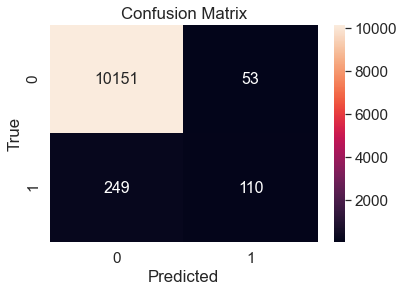

In [18]:
fig = plot_confusion_matrix(valid_y, pred_valid)
fig.savefig(path.BASE_PATH/'../figures/Initial_HistGBC_ cm.jpg', dpi=1000, bbox_inches='tight')

In [19]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8702865444650576
APRC: 0.41466504174438334
Percision: 0.6748466257668712
Recall: 0.3064066852367688
ACC: 0.9714096374136135
F1: 0.421455938697318
F2: 0.3439649781113196
F5: 0.3129787699715474
F10: 0.3080719851371212


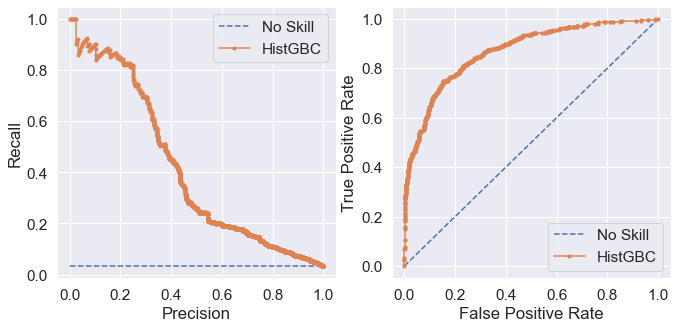

In [20]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')
fig.savefig(path.BASE_PATH/'../figures/Initial_HistGBC_aucs.jpg', dpi=1000, bbox_inches='tight')

In [23]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc')
_, _, prob_valid, pred_valid = fit(m, sample_weight=sample_weight);

Binning 0.043 GB of training data: 0.297 s
Binning 0.005 GB of validation data: 0.023 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.86863, val score: 0.82436, in 0.064s
[2/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.87229, val score: 0.82916, in 0.070s
[3/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.87745, val score: 0.83294, in 0.062s
[4/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.88925, val score: 0.83655, in 0.059s
[5/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.89020, val score: 0.83568, in 0.059s
[6/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.89523, val score: 0.83917, in 0.060s
[7/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.89841, val score: 0.84275, in 0.066s
[8/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.90059, val score: 0.84314, in 0.060s
[9/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.90625, val score: 0.84334, in 0.063s
[10/1000] 1 tree, 31 le

[85/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.98366, val score: 0.89008, in 0.092s
[86/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.98386, val score: 0.89067, in 0.124s
[87/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.98406, val score: 0.89086, in 0.140s
[88/1000] 1 tree, 31 leaves, max depth = 14, train score: 0.98434, val score: 0.89108, in 0.135s
[89/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.98461, val score: 0.89152, in 0.085s
[90/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.98497, val score: 0.89129, in 0.107s
[91/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.98526, val score: 0.89148, in 0.086s
[92/1000] 1 tree, 31 leaves, max depth = 13, train score: 0.98553, val score: 0.89209, in 0.089s
[93/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.98598, val score: 0.89234, in 0.088s
[94/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.98620, val score: 0.89247, in 0.088s
[95/1000] 1 tree, 31 leaves, max 

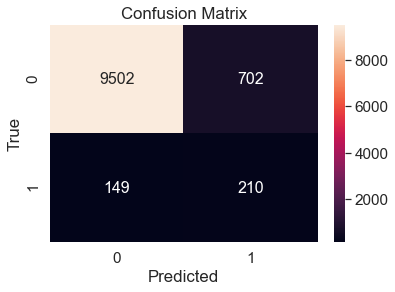

In [26]:
fig = plot_confusion_matrix(valid_y, pred_valid)
fig.savefig(path.BASE_PATH/'../figures/Initial_weighted_HistGBC_cm.jpg', dpi=1000, bbox_inches='tight')

In [27]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8687870505749562
APRC: 0.3960291105342006
Percision: 0.23026315789473684
Recall: 0.584958217270195
ACC: 0.9194357663542554
F1: 0.3304484657749803
F2: 0.44718909710391824
F5: 0.5522403155658946
F10: 0.5761708138650441


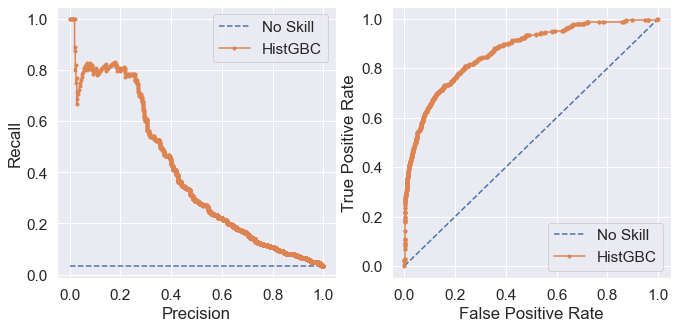

In [28]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')
fig.savefig(path.BASE_PATH/'../figures/Initial_weighted_HistGBC_aucs.jpg', dpi=1000, bbox_inches='tight')

In [36]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1, l2_regularization=2.4,
                             learning_rate=0.03, max_depth=25, max_iter=1000, max_leaf_nodes=44,
                             min_samples_leaf=8,  scoring='roc_auc', tol=1e-8)
_, _, prob_valid, pred_valid = fit(m);

Binning 0.043 GB of training data: 0.271 s
Binning 0.005 GB of validation data: 0.019 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.85729, val score: 0.82124, in 0.056s
[2/1000] 1 tree, 44 leaves, max depth = 9, train score: 0.86568, val score: 0.83626, in 0.057s
[3/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.86604, val score: 0.84437, in 0.064s
[4/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.87164, val score: 0.85468, in 0.057s
[5/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.87213, val score: 0.85706, in 0.061s
[6/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.87276, val score: 0.85612, in 0.068s
[7/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.87284, val score: 0.85519, in 0.068s
[8/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.87246, val score: 0.85578, in 0.092s
[9/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.87602, val score: 0.85660, in 0.088s
[10/1000] 1 tree

[85/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.93562, val score: 0.88889, in 0.108s
[86/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.93610, val score: 0.88936, in 0.097s
[87/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.93680, val score: 0.88975, in 0.159s
[88/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.93735, val score: 0.89027, in 0.100s
[89/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.93794, val score: 0.89052, in 0.099s
[90/1000] 1 tree, 44 leaves, max depth = 9, train score: 0.93848, val score: 0.89068, in 0.109s
[91/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.93886, val score: 0.89109, in 0.089s
[92/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.93951, val score: 0.89131, in 0.088s
[93/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.94013, val score: 0.89170, in 0.091s
[94/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.94058, val score: 0.89232, in 0.091s
[95/1000] 1 tree, 44 leaves, ma

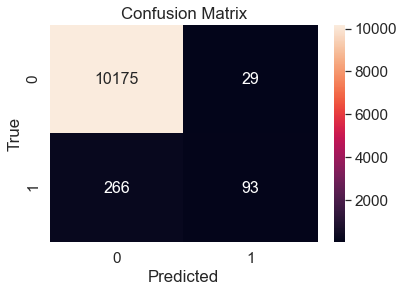

In [39]:
fig = plot_confusion_matrix(valid_y, pred_valid)
#fig.savefig(path.BASE_PATH/'../figures/RFparams_HistGBC_cm.jpg', dpi=1000, bbox_inches='tight')

In [40]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.878258184839852
APRC: 0.43279331138775684
Percision: 0.7622950819672131
Recall: 0.2590529247910863
ACC: 0.972072327937139
F1: 0.38669438669438666
F2: 0.2984595635430038
F5: 0.26580191271847864
F10: 0.26075731497418236


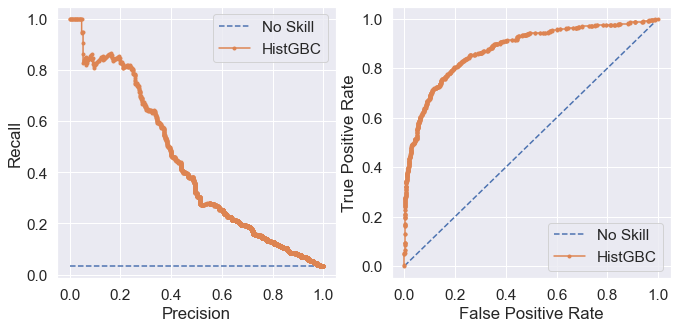

In [41]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')
#fig.savefig(path.BASE_PATH/'../figures/RFparams_HistGBC_aucs.jpg', dpi=1000, bbox_inches='tight')

In [43]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1, l2_regularization=2.4,
                             learning_rate=0.03, max_depth=25, max_iter=1000, max_leaf_nodes=44,
                             min_samples_leaf=8,  scoring='roc_auc', tol=1e-8)
_, _, prob_valid, pred_valid = fit(m, sample_weight=sample_weight);

Binning 0.043 GB of training data: 0.300 s
Binning 0.005 GB of validation data: 0.020 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.88001, val score: 0.79416, in 0.066s
[2/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.88305, val score: 0.79974, in 0.071s
[3/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.88296, val score: 0.80287, in 0.074s
[4/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.88361, val score: 0.81221, in 0.077s
[5/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.88447, val score: 0.81289, in 0.073s
[6/1000] 1 tree, 44 leaves, max depth = 9, train score: 0.88811, val score: 0.81550, in 0.080s
[7/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.88982, val score: 0.81659, in 0.122s
[8/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.89115, val score: 0.81511, in 0.077s
[9/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.89312, val score: 0.81471, in 0.097s
[10/1000] 1 tree

[85/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.95484, val score: 0.85903, in 0.181s
[86/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.95547, val score: 0.85936, in 0.101s
[87/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.95576, val score: 0.85957, in 0.101s
[88/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.95631, val score: 0.85993, in 0.102s
[89/1000] 1 tree, 44 leaves, max depth = 17, train score: 0.95652, val score: 0.86023, in 0.099s
[90/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.95672, val score: 0.86043, in 0.123s
[91/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.95726, val score: 0.86083, in 0.106s
[92/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.95765, val score: 0.86079, in 0.103s
[93/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.95807, val score: 0.86185, in 0.109s
[94/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.95869, val score: 0.86223, in 0.112s
[95/1000] 1 tree, 44 leaves, m

[169/1000] 1 tree, 44 leaves, max depth = 17, train score: 0.97897, val score: 0.87381, in 0.155s
[170/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.97923, val score: 0.87421, in 0.151s
[171/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.97941, val score: 0.87446, in 0.188s
[172/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.97962, val score: 0.87460, in 0.171s
[173/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.97974, val score: 0.87443, in 0.263s
[174/1000] 1 tree, 44 leaves, max depth = 10, train score: 0.97989, val score: 0.87461, in 0.300s
[175/1000] 1 tree, 44 leaves, max depth = 19, train score: 0.98014, val score: 0.87456, in 0.155s
[176/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.98024, val score: 0.87473, in 0.159s
[177/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.98038, val score: 0.87485, in 0.148s
[178/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.98055, val score: 0.87459, in 0.152s
[179/1000] 1 tree, 4

[253/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.98922, val score: 0.87978, in 0.448s
[254/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.98927, val score: 0.87975, in 0.436s
[255/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.98935, val score: 0.87995, in 0.232s
[256/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.98942, val score: 0.87990, in 0.363s
[257/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.98947, val score: 0.87984, in 0.373s
[258/1000] 1 tree, 44 leaves, max depth = 18, train score: 0.98956, val score: 0.87962, in 0.202s
[259/1000] 1 tree, 44 leaves, max depth = 16, train score: 0.98962, val score: 0.87963, in 0.316s
[260/1000] 1 tree, 44 leaves, max depth = 9, train score: 0.98969, val score: 0.87980, in 0.314s
[261/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.98977, val score: 0.87993, in 0.187s
[262/1000] 1 tree, 44 leaves, max depth = 18, train score: 0.98982, val score: 0.88005, in 0.199s
[263/1000] 1 tree, 44

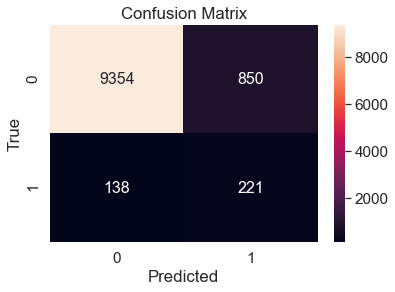

In [44]:
fig = plot_confusion_matrix(valid_y, pred_valid)
#fig.savefig(path.BASE_PATH/'../figures/RFparams_weighted_HistGBC_Confusion_Matrix.jpg', dpi=1000, bbox_inches='tight')

In [45]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8703886399893428
APRC: 0.4126682014313449
Percision: 0.20634920634920634
Recall: 0.6155988857938719
ACC: 0.9064659661081133
F1: 0.3090909090909091
F2: 0.440765855604308
F5: 0.571968942862831
F10: 0.603743474615239


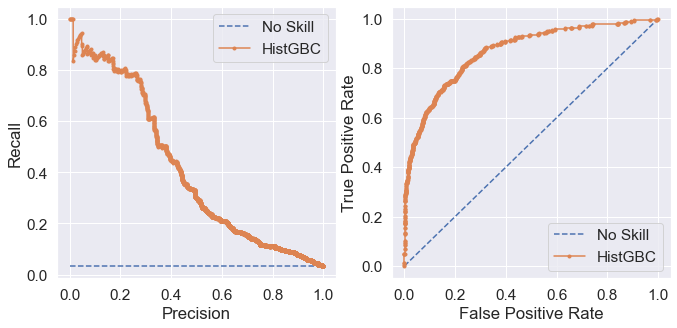

In [46]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')
#fig.savefig(path.BASE_PATH/'../figures/RFparams_weighted_HistGBC_aucs.jpg', dpi=1000, bbox_inches='tight')

# Important features

In [47]:
xs_imp = (path/'xs_imp.pkl').load()
valid_xs_imp = (path/'valid_xs_imp.pkl').load()

In [48]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1, l2_regularization=2.4,
                             learning_rate=0.03, max_depth=25, max_iter=1000, max_leaf_nodes=44,
                             min_samples_leaf=8,  scoring='roc_auc', tol=1e-8)
_, _, baseline_prob, baseline_pred = fit(m)

Binning 0.043 GB of training data: 0.271 s
Binning 0.005 GB of validation data: 0.019 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.82293, val score: 0.80911, in 0.218s
[2/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.82762, val score: 0.81757, in 0.061s
[3/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.84679, val score: 0.83022, in 0.060s
[4/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.85965, val score: 0.84550, in 0.062s
[5/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.86098, val score: 0.84723, in 0.067s
[6/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.86545, val score: 0.85131, in 0.113s
[7/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.86632, val score: 0.85198, in 0.071s
[8/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.86759, val score: 0.85186, in 0.070s
[9/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.87197, val score: 0.85960, in 0.074s
[10/1000] 1 tre

[85/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.92841, val score: 0.89662, in 0.100s
[86/1000] 1 tree, 44 leaves, max depth = 12, train score: 0.92918, val score: 0.89672, in 0.100s
[87/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.93012, val score: 0.89687, in 0.100s
[88/1000] 1 tree, 44 leaves, max depth = 17, train score: 0.93077, val score: 0.89714, in 0.199s
[89/1000] 1 tree, 44 leaves, max depth = 14, train score: 0.93145, val score: 0.89733, in 0.098s
[90/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.93196, val score: 0.89725, in 0.102s
[91/1000] 1 tree, 44 leaves, max depth = 11, train score: 0.93260, val score: 0.89722, in 0.102s
[92/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.93352, val score: 0.89720, in 0.099s
[93/1000] 1 tree, 44 leaves, max depth = 13, train score: 0.93413, val score: 0.89704, in 0.099s
[94/1000] 1 tree, 44 leaves, max depth = 15, train score: 0.93462, val score: 0.89694, in 0.102s
[95/1000] 1 tree, 44 leaves, m

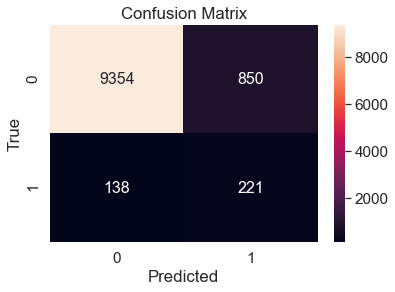

In [49]:
fig = plot_confusion_matrix(valid_y, pred_valid)

In [50]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8703886399893428
APRC: 0.4126682014313449
Percision: 0.20634920634920634
Recall: 0.6155988857938719
ACC: 0.9064659661081133
F1: 0.3090909090909091
F2: 0.440765855604308
F5: 0.571968942862831
F10: 0.603743474615239


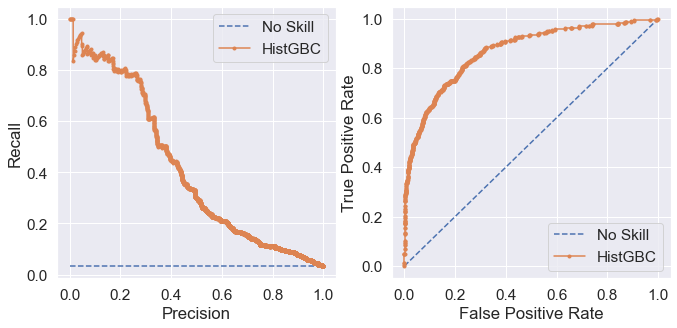

In [51]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')

# Hyperparameter tuning

Hyperparameters were tuned interatively using GridSearchCV. 

In [52]:
xs_imp.shape, y.shape, valid_xs_imp.shape, valid_y.shape

((48491, 61), (48491,), (10563, 61), (10563,))

In [77]:
HistGradientBoostingClassifier?

In [75]:
parameters1 = {
 'max_depth': [15],
 'random_state': [33],
 }

In [93]:
parameters2 = {
 'max_depth': [15],
 'learning_rate': [0.1],
 'random_state': [33],
 }

In [132]:
parameters3 = {
 'max_depth': [15],
 'learning_rate': [0.1], 
 'l2_regularization': [4.0],
 'random_state': [33],
 }

In [149]:
parameters4 = {
 'max_depth': [15],
 'learning_rate': [0.1], 
 'l2_regularization': [4.0],
 'min_samples_leaf': [20],
 'random_state': [33],
 }

In [159]:
parameters5 = {
 'max_depth': [15],
 'learning_rate': [0.1], 
 'l2_regularization': [4.0],
 'min_samples_leaf': [20],
 'max_leaf_nodes': [31],
 'random_state': [33],
 }

In [175]:
parameters6 = {
 'max_depth': [15],
 'learning_rate': [0.1], 
 'l2_regularization': [4.0],
 'min_samples_leaf': [20],
 'max_leaf_nodes': [31],
 'tol': [1e-8]
 'random_state': [33],
 }

In [176]:
clf = GridSearchCV(HistGradientBoostingClassifier(loss='binary_crossentropy', max_iter=1000, 
                                                  scoring='roc_auc', tol=1e-8), parameters6, 
                   scoring=make_scorer(roc_auc_score, needs_proba=True), n_jobs=-1, cv=3,
                   verbose=3)

In [177]:
%%time
clf.fit(xs, y)
clf.best_estimator_, clf.best_score_, clf.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:  2.6min remaining: 12.8min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  4.7min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  5.9min finished


CPU times: user 3min 45s, sys: 1min 27s, total: 5min 13s
Wall time: 6min 48s


(HistGradientBoostingClassifier(l2_regularization=4.0,
                                loss='binary_crossentropy', max_depth=15,
                                max_iter=1000, random_state=33,
                                scoring='roc_auc', tol=1e-08),
 0.8963061409318414,
 {'l2_regularization': 4.0,
  'learning_rate': 0.1,
  'max_depth': 15,
  'max_leaf_nodes': 31,
  'min_samples_leaf': 20,
  'random_state': 33,
  'tol': 1e-08})

In [57]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc',
                                    max_depth=15, learning_rate=0.1,
                                    l2_regularization=4.0)
_, _, baseline_prob, baseline_pred = fit(m)

Binning 0.043 GB of training data: 0.347 s
Binning 0.005 GB of validation data: 0.026 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.82507, val score: 0.82837, in 0.059s
[2/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.84176, val score: 0.84451, in 0.066s
[3/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.84749, val score: 0.84874, in 0.078s
[4/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.85676, val score: 0.85706, in 0.075s
[5/1000] 1 tree, 31 leaves, max depth = 13, train score: 0.87474, val score: 0.86346, in 0.054s
[6/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.87471, val score: 0.86605, in 0.054s
[7/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.87829, val score: 0.86789, in 0.056s
[8/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.88386, val score: 0.86793, in 0.056s
[9/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.88653, val score: 0.86932, in 0.059s
[10/1000] 1 tree, 3

[85/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.96093, val score: 0.89562, in 0.149s
[86/1000] 1 tree, 31 leaves, max depth = 14, train score: 0.96148, val score: 0.89604, in 0.085s
[87/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.96177, val score: 0.89641, in 0.073s
[88/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.96220, val score: 0.89678, in 0.073s
[89/1000] 1 tree, 31 leaves, max depth = 13, train score: 0.96267, val score: 0.89717, in 0.077s
[90/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.96307, val score: 0.89708, in 0.070s
[91/1000] 1 tree, 31 leaves, max depth = 14, train score: 0.96324, val score: 0.89745, in 0.075s
[92/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.96342, val score: 0.89741, in 0.073s
[93/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.96416, val score: 0.89772, in 0.116s
[94/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.96436, val score: 0.89756, in 0.128s
[95/1000] 1 tree, 31 leaves, max 

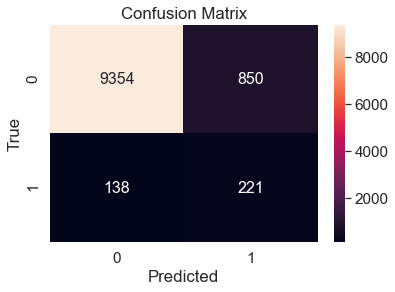

In [58]:
fig = plot_confusion_matrix(valid_y, pred_valid)

In [59]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8703886399893428
APRC: 0.4126682014313449
Percision: 0.20634920634920634
Recall: 0.6155988857938719
ACC: 0.9064659661081133
F1: 0.3090909090909091
F2: 0.440765855604308
F5: 0.571968942862831
F10: 0.603743474615239


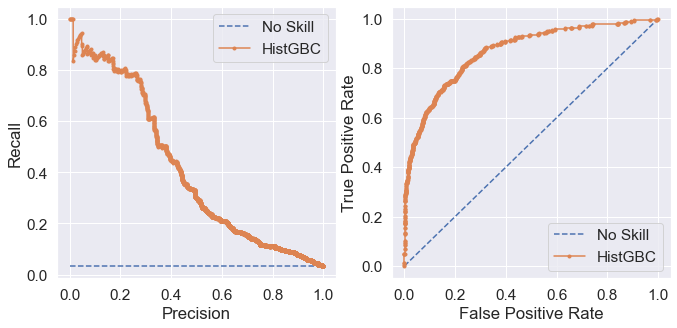

In [60]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')

In [78]:
m.predict?

In [76]:
%%time
m = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc',
                                    max_depth=15, learning_rate=0.1,
                                    l2_regularization=4.0)
_, _, prob_valid, pred_valid = fit(m, sample_weight=sample_weight)

Binning 0.043 GB of training data: 0.276 s
Binning 0.005 GB of validation data: 0.016 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.84796, val score: 0.84266, in 0.047s
[2/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.85661, val score: 0.84793, in 0.051s
[3/1000] 1 tree, 31 leaves, max depth = 7, train score: 0.86409, val score: 0.85847, in 0.050s
[4/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.86515, val score: 0.86554, in 0.051s
[5/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.86718, val score: 0.86323, in 0.055s
[6/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.87028, val score: 0.86428, in 0.052s
[7/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.87477, val score: 0.86792, in 0.069s
[8/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.87795, val score: 0.87116, in 0.054s
[9/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.88176, val score: 0.87383, in 0.055s
[10/1000] 1 tree, 3

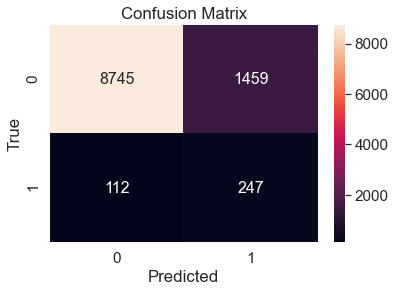

In [73]:
fig = plot_confusion_matrix(valid_y, pred_valid)

In [74]:
metrics(valid_y, pred_valid, prob_valid, acc=True);

AROC: 0.8726767808571437
APRC: 0.40095224084645265
Percision: 0.1447831184056272
Recall: 0.6880222841225627
ACC: 0.8512733125059169
F1: 0.23922518159806294
F2: 0.39306174411203054
F5: 0.6012545641793839
F10: 0.6633781843322876


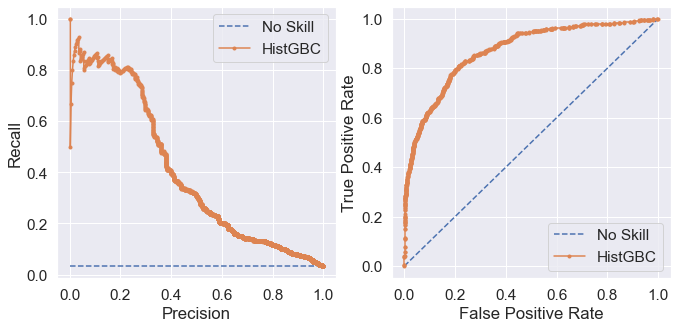

In [75]:
fig = plot_roc_prc(valid_y, prob_valid, label='HistGBC')

## Including the V*** columns

In [194]:
to = (path/'to_full.pkl').load()

xs, y             = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [195]:
cats = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
       'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 
       'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 
       'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 
       'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38']

for cat in cats:
    to[cat] = to[cat].astype('category')

In [196]:
%%time
clf = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc',
                                    max_depth=15, learning_rate=0.1,
                                    l2_regularization=4.0, tol=1e-8)
clf.fit(xs,y)
m_roc(y, xs), m_roc(valid_y, valid_xs)

Binning 0.279 GB of training data: 1.745 s
Binning 0.031 GB of validation data: 0.042 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.84101, val score: 0.85701, in 0.156s
[2/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.86369, val score: 0.87599, in 0.177s
[3/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.86724, val score: 0.87988, in 0.157s
[4/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.87065, val score: 0.88631, in 0.183s
[5/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.87563, val score: 0.89064, in 0.162s
[6/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.87965, val score: 0.89242, in 0.225s
[7/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.88089, val score: 0.89431, in 0.253s
[8/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.88305, val score: 0.89610, in 0.255s
[9/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.88634, val score: 0.89780, in 0.227s
[10/1000] 1 tree, 31

[85/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.95748, val score: 0.92662, in 0.304s
[86/1000] 1 tree, 31 leaves, max depth = 13, train score: 0.95765, val score: 0.92687, in 0.312s
[87/1000] 1 tree, 31 leaves, max depth = 15, train score: 0.95855, val score: 0.92688, in 0.317s
[88/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.95911, val score: 0.92699, in 0.492s
[89/1000] 1 tree, 31 leaves, max depth = 15, train score: 0.95927, val score: 0.92696, in 0.580s
[90/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.95956, val score: 0.92701, in 0.340s
[91/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.96012, val score: 0.92770, in 0.353s
[92/1000] 1 tree, 31 leaves, max depth = 14, train score: 0.96034, val score: 0.92785, in 0.309s
[93/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.96072, val score: 0.92811, in 0.507s
[94/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.96092, val score: 0.92817, in 0.518s
[95/1000] 1 tree, 31 leaves, max

(0.9662431693097167, 0.8943595769682725)

## Only features deemed important by RF model interpretation with V*** features

In [205]:
xs_imp = (path/'xs_imp_full.pkl').load()
valid_xs_imp = (path/'valid_xs_imp_full.pkl').load()

In [206]:
%%time
clf = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc',
                                    max_depth=15, learning_rate=0.1,
                                    l2_regularization=4.0, tol=1e-8)
clf.fit(xs_imp,y)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

Binning 0.011 GB of training data: 0.114 s
Binning 0.001 GB of validation data: 0.006 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.85183, val score: 0.82808, in 0.034s
[2/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.85846, val score: 0.83773, in 0.034s
[3/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.86037, val score: 0.84088, in 0.033s
[4/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.86785, val score: 0.85493, in 0.035s
[5/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.86885, val score: 0.85801, in 0.052s
[6/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.87304, val score: 0.85900, in 0.032s
[7/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.87515, val score: 0.86176, in 0.032s
[8/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.87517, val score: 0.86165, in 0.025s
[9/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.87960, val score: 0.86407, in 0.042s
[10/1000] 1 tree, 3

(0.9433326003871689, 0.8825521657999629)

## Only features deemed important by RF model interpretation

In [26]:
xs_imp = (path/'xs_imp.pkl').load()
valid_xs_imp = (path/'valid_xs_imp.pkl').load()

In [29]:
%%time
clf = HistGradientBoostingClassifier(loss='binary_crossentropy', verbose=1,
                                    max_iter=1000, scoring='roc_auc',
                                    max_depth=15, learning_rate=0.1,
                                    l2_regularization=4.0, tol=1e-8)
clf.fit(xs_imp,y)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

Binning 0.021 GB of training data: 0.175 s
Binning 0.002 GB of validation data: 0.014 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.83554, val score: 0.84848, in 0.066s
[2/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.86201, val score: 0.86134, in 0.057s
[3/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.86932, val score: 0.85516, in 0.054s
[4/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.87211, val score: 0.85237, in 0.064s
[5/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.87514, val score: 0.86356, in 0.062s
[6/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.87806, val score: 0.86451, in 0.062s
[7/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.88273, val score: 0.87102, in 0.058s
[8/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.88680, val score: 0.87063, in 0.063s
[9/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.88888, val score: 0.87139, in 0.064s
[10/1000] 1 tree, 3

[85/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.96862, val score: 0.89220, in 0.090s
[86/1000] 1 tree, 31 leaves, max depth = 13, train score: 0.96893, val score: 0.89226, in 0.091s
[87/1000] 1 tree, 31 leaves, max depth = 11, train score: 0.96921, val score: 0.89290, in 0.097s
[88/1000] 1 tree, 31 leaves, max depth = 12, train score: 0.96945, val score: 0.89278, in 0.088s
[89/1000] 1 tree, 31 leaves, max depth = 10, train score: 0.96964, val score: 0.89237, in 0.097s
[90/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.97007, val score: 0.89279, in 0.094s
[91/1000] 1 tree, 31 leaves, max depth = 13, train score: 0.97036, val score: 0.89320, in 0.090s
[92/1000] 1 tree, 31 leaves, max depth = 9, train score: 0.97051, val score: 0.89343, in 0.087s
[93/1000] 1 tree, 31 leaves, max depth = 8, train score: 0.97072, val score: 0.89323, in 0.087s
[94/1000] 1 tree, 31 leaves, max depth = 14, train score: 0.97110, val score: 0.89335, in 0.088s
[95/1000] 1 tree, 31 leaves, max d

(0.9687158661985884, 0.8810013878439718)

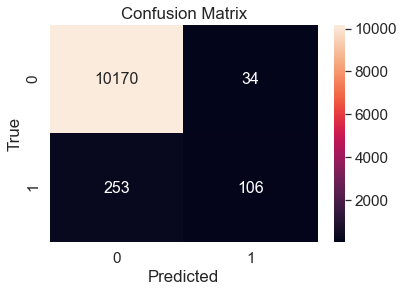

In [35]:
fig = plot_confusion_matrix(valid_y, clf.predict(valid_xs_imp))
fig.savefig(path.BASE_PATH/'../figures/GBT_imp_Confusion_Matrix.jpg', dpi=1000, bbox_inches='tight')

## XGBoost

In [11]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [13]:
xs, y = (path/'xs.pkl').load(), (path/'y.pkl').load()
valid_xs, valid_y = (path/'valid_xs.pkl').load(), (path/'valid_y.pkl').load()